# Predicting the criticality of a aircraft fault by description #

## Introduction ##

This data set contains information of all corrective actions that were opened in a brazilian aircraft fleet between 2018 and 2019. I approach one question regarding if it’s possible to predict the criticality of a fault by the description provided by the person that had opened the fault. To answer this question I will use the bag of words method and machine learning models.

## 1. Importing libraries and understading the Dataset


In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from io import StringIO
%matplotlib inline

import json

In [2]:
df = pd.read_csv(r'C:\Users\4222416\Downloads\A320_dataset.csv',encoding='latin-1', delimiter=';')

df.head()

,aircraft_tail,aircraft_msn,fault_source,deferral_reference,deferral_class,logbook_type,event_type,event_status,fault_name,description,...,fleet,actual_end_date,fleet_type,fleet_holding,extended_due_date,condicion_mapi,causa,type,type_latam,fault_count
0,PR-MYC,3733,PILOT,27-00-01A,MEL C,MAINT,CF,CFCERT,COND PUSHBBUTTON LIGHT ON ECAM CTL PNL INOPERA...,<b><u>REINALDO DE ALMEIDA BARBOSA 28-MAR-2018 ...,...,A320FAM,08/04/2018 08:16,NB,BR,07/04/2018 23:59,LIMPIO,#NOME?,TECH,TECH,FAULT
1,PR-MHP,3266,MECH,36-00-01A,MEL C,MAINT,CF,CFCERT,AIR BLEED MAINTENANCE MESSAGE ON THE STATUS PA...,AIR BLEED MAINTENANCE MESSAGE ON THE STATUS ...,...,A320FAM,22/12/2018 07:00,NB,BR,21/12/2018 23:59,LIMPIO,#NOME?,TECH,TECH,REPEATED
2,PT-MXQ,6165,PILOT,74-31-01A,MEL C,MAINT,CF,CFCERT,ENG 1 IGN A FAULT DURING ENG START. IGNITION S...,NaN,...,A320FAM,04/01/2019 20:11,NB,BR,14/01/2019 23:59,LIMPIO,#NOME?,TECH,TECH,REPEATED
3,PR-MAK,1825,PILOT,21-26-01A,MEL C,CABIN,CF,CFCERT,VENT BLOWER FAULT AVIONICS EQUIPMENT VENTILATION,VENT BLOWER FAULT,...,A320FAM,23/09/2019 06:00,NB,BR,30/09/2019 23:59,LIMPIO,#NOME?,TECH,TECH,REPEATED
4,PT-MZY,1628,MECH,33-01-01-01A,MEL C,MAINT,CF,CFCERT,ANN LT TEST SWITCH DOES NOT CHANGE LIGHT INTEN...,ANN LT TEST SWITCH DOES NOT CHANGE LIGHT INTEN...,...,A320FAM,11/02/2019 06:39,NB,BR,20/02/2019 23:59,LIMPIO,#NOME?,TECH,TECH,FAULT


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22904 entries, 0 to 22903
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   aircraft_tail                     22904 non-null  object 
 1   aircraft_msn                      22904 non-null  int64  
 2   fault_source                      22904 non-null  object 
 3   deferral_reference                22896 non-null  object 
 4   deferral_class                    22904 non-null  object 
 5   logbook_type                      20279 non-null  object 
 6   event_type                        22904 non-null  object 
 7   event_status                      22904 non-null  object 
 8   fault_name                        22904 non-null  object 
 9   description                       22129 non-null  object 
 10  creation_date                     22904 non-null  object 
 11  found_on_date                     22904 non-null  object 
 12  work

In [4]:
df.describe()

,aircraft_msn,life_time,ata_2d,ata_4d,ata_6d,moc
count,22904.000000,22904.000000,22904.000000,22904.000000,22904.000000,2.000000
mean,3891.533313,4.230091,32.480265,3280.736116,328075.341774,423337.000000
std,1793.776241,22.683919,12.135907,1207.507920,120750.060475,109378.105341
min,1143.000000,-22.000000,0.000000,40.000000,4000.000000,345995.000000
25%,1891.000000,1.000000,25.000000,2518.000000,251800.000000,384666.000000
50%,3662.000000,3.000000,32.000000,3242.000000,324200.000000,423337.000000
75%,5345.000000,5.000000,35.000000,3530.000000,353000.000000,462008.000000
max,9324.000000,2924.000000,80.000000,8013.000000,801300.000000,500679.000000


## 2. Data Preparation

#### Check and impute missing values

In [5]:
def missing_values_table(df):
    '''
    Input - Dataframe that has all relevant variables for consideration.
    
    Output - Displays the total number of variables/columns in the dataset. In addition, it also 
    generates count of missing values for each column.
    
    '''    
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
    "There are " + str(mis_val_table_ren_columns.shape[0]) +
    " columns that have missing values.")
    return mis_val_table_ren_columns
    
df_qa=missing_values_table(df)
df_qa

Your selected dataframe has 41 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
moc,22902,100.0
logbook_type,2625,11.5
found_during_flight,2360,10.3
flight_arrival_airport,2360,10.3
description,775,3.4
corrective_action,65,0.3
deferral_reference,8,0.0
fault_due_date,2,0.0
extended_due_date,2,0.0


#### Data Cleaning: The columns below don't presented any relevant information to our analysis

In [6]:
df=df.drop(['aircraft_msn','workpackage_name','workpackage_scheduled_start_date','workpackage_actual_start_date','causa','fault_count','condicion_mapi','deferral_reference','event_type','found_during_flight','aircraft_assembly','config_slot_details','maintenance_airline_code','maintenance_airline_code_group','fleet_type','fleet_holding','type','type_latam','moc'],axis=1)
df.head()

,aircraft_tail,fault_source,deferral_class,logbook_type,event_status,fault_name,description,creation_date,found_on_date,complete_date,...,corrective_action,task_status,flight_arrival_airport,fault_due_date,ata_2d,ata_4d,ata_6d,fleet,actual_end_date,extended_due_date
0,PR-MYC,PILOT,MEL C,MAINT,CFCERT,COND PUSHBBUTTON LIGHT ON ECAM CTL PNL INOPERA...,<b><u>REINALDO DE ALMEIDA BARBOSA 28-MAR-2018 ...,28/03/2018,28/03/2018,08/04/2018,...,7665744. 2018-04-03 04:48:45 NO SPARE TOOL...,COMPLETE,SDU,07/04/2018 23:59,27,2792,279200,A320FAM,08/04/2018 08:16,07/04/2018 23:59
1,PR-MHP,MECH,MEL C,MAINT,CFCERT,AIR BLEED MAINTENANCE MESSAGE ON THE STATUS PA...,AIR BLEED MAINTENANCE MESSAGE ON THE STATUS ...,11/12/2018,11/12/2018,22/12/2018,...,8639210. 2018-12-20 06:25:36 TAREFA NÃO RE...,COMPLETE,GRU,21/12/2018 23:59,36,3611,361100,A320FAM,22/12/2018 07:00,21/12/2018 23:59
2,PT-MXQ,PILOT,MEL C,MAINT,CFCERT,ENG 1 IGN A FAULT DURING ENG START. IGNITION S...,NaN,04/01/2019,04/01/2019,04/01/2019,...,8691543. 2019-01-04 20:12:40 item foi lanç...,COMPLETE,GRU,14/01/2019 23:59,74,7431,743100,A320FAM,04/01/2019 20:11,14/01/2019 23:59
3,PR-MAK,PILOT,MEL C,CABIN,CFCERT,VENT BLOWER FAULT AVIONICS EQUIPMENT VENTILATION,VENT BLOWER FAULT,20/09/2019,20/09/2019,23/09/2019,...,9754356. 2019-09-22 04:04:32 TAREFA PARALI...,COMPLETE,LDB,30/09/2019 23:59,21,2126,212600,A320FAM,23/09/2019 06:00,30/09/2019 23:59
4,PT-MZY,MECH,MEL C,MAINT,CFCERT,ANN LT TEST SWITCH DOES NOT CHANGE LIGHT INTEN...,ANN LT TEST SWITCH DOES NOT CHANGE LIGHT INTEN...,10/02/2019,10/02/2019,11/02/2019,...,8835307. 2019-02-11 06:39:39 LABOR 8835...,COMPLETE,NaN,20/02/2019 23:59,33,3314,331400,A320FAM,11/02/2019 06:39,20/02/2019 23:59


## 3. Exploratory Data Analysis

### Questions

The exploratory data analysis will help us understand some key figures points about the business without running any model. Many actions can be generated based only on a good analysis and data visualization to mitigate problems that are already happening.


1. Which aircraft had the most faults?
2. How many faults generated a AOG(Aircraft on Ground)?
3. Which ATA has more faults?
4. Which day had the most faults executed?

#### 1. Which aircraft had the most faults?

In [7]:
# Which aircraft had the most faults?
dff = df.groupby('aircraft_tail') \
       .agg({'barcode':'count'}) \
       .rename(columns={'barcode':'faults'}) \
       .reset_index()
faults_per_acft = dff.sort_values('faults', ascending = False)
faults_per_acft

,aircraft_tail,faults
6,PR-MAN,288
32,PR-MHK,275
100,PT-MZG,268
15,PR-MBG,267
38,PR-MHW,264
...,...,...
75,PR-TYT,14
82,PR-XBE,13
76,PR-TYU,2
77,PR-TYV,1


Text(0.5, 1.0, 'Faults x Age')

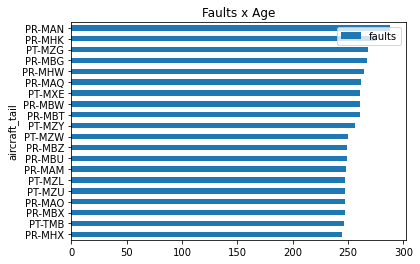

In [8]:
faults_per_acft[:20].plot(kind='barh', x='aircraft_tail')
plt.gca().invert_yaxis()
plt.title('Faults x Age')


Here we can see a huge difference between the aircrafts. This analysis can lead us to a closer approach with the engineering team to discover some technical patterns in the worst aircrafts.

#### 2. How many faults generated a AOG(Aircraft on Ground)?

life_time
-22         1
 0       1413
 1       4600
 2       4738
 3       3158
         ... 
 366        1
 379        1
 511        1
 1472       1
 2924       1
Name: barcode, Length: 79, dtype: int64

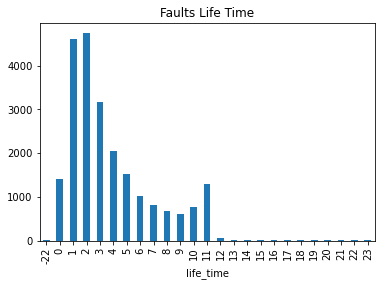

In [9]:
# How many faults generated a AOG(Aircraft on Ground)?
fault_life_time = df.groupby(['life_time'])['barcode'].nunique()
fault_life_time[:25].plot(kind='bar')
plt.title('Faults Life Time')
fault_life_time

In [10]:
aog = df.loc[(df['life_time']) >= 10]
aog.describe()

,life_time,ata_2d,ata_4d,ata_6d
count,2318.000000,2318.000000,2318.000000,2318.000000
mean,15.068594,34.453840,3475.299827,347531.434426
std,70.071546,14.900542,1484.790493,148478.517671
min,10.000000,5.000000,500.000000,50000.000000
25%,10.000000,25.000000,2520.000000,252000.000000
50%,11.000000,32.000000,3244.000000,324416.000000
75%,11.000000,36.000000,3611.000000,361100.000000
max,2924.000000,80.000000,8011.000000,801100.000000


2318 faults were executed after 10 days, generating a AOG(Aircraft on Ground)

#### 3. Which ATA has more faults?

ATA is a numbering system which is a common referencing standard for commercial aircraft documentation. This commonality permits greater ease of learning and understanding for pilots, aircraft maintenance technicians, and engineers alike. Analyzing the ATA will lead to know what system had more failures.

Text(0.5, 1.0, 'Top 10 ATA')

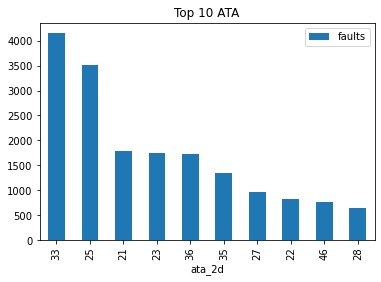

In [11]:
df_ata_2d = df.groupby('ata_2d') \
       .agg({'barcode':'count'}) \
       .rename(columns={'barcode':'faults'}) \
       .reset_index()
df_ata_2d = df_ata_2d.sort_values('faults', ascending = False)
df_ata_2d
df_ata_2d[:10].plot(kind='bar', x='ata_2d')
plt.title('Top 10 ATA')

The ATA 33 which refers to LIGHTS had the most faults in 2019 and 2018.

#### 4. Which day had the most faults executed?

    complete_date  faults
206    09/08/2019      60
188    08/11/2019      57
564    24/07/2019      55
386    17/02/2019      53
422    18/08/2019      53
..            ...     ...
417    18/06/2018      14
362    16/02/2019      14
129    06/06/2018      14
21     01/12/2018      12
116    05/11/2019      10

[728 rows x 2 columns]


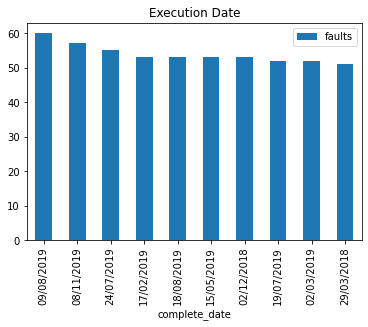

In [12]:
df_month = df.groupby('complete_date') \
       .agg({'barcode':'count'}) \
       .rename(columns={'barcode':'faults'}) \
       .reset_index()
df_month2 = df_month.sort_values('faults', ascending = False)
df_month2
df_month2[:10].plot(kind='bar', x='complete_date')
plt.title('Execution Date')
print(df_month2)

## 4. Data Modeling

To predict the criticality of a fault first it’s necessary to classify those tasks between: normal, risk and AOG. By default these aircrafts stop every 3 days to do maintenance checks, so if the fault was executed between 0 and 6 days, meaning between 1 and 2 stops, it’s considered a low risk fault. If the execution happened between 6 and 9 days after the opening, or 3 stops, it's a high risk fault. If the execution took more than 10 days it means that the fault had to be executed while the aircraft was unable to fly due to the brazilian regulation. The rule for this type of fault it’s that if it’s not executed after 10 days the aircraft must remain on ground. It doesn't matter if it's a broken seat or a passenger reading light that it´ s inoperative, the aircraft cannot perform any flight.

### 4.1 Creating a new column with fault criticality. ##

In [13]:
# create a function to classify the criticality of the faults
# if the fault was executed in 5 days or less it´s a normal life time, between 6 and 9 days it's risk, 
#after 10 days it means that the aircraft had to stay on the ground due to regulations

def get_criticality(df):
        if df['life_time'] <= 5:
            return "NORMAL"
        elif df['life_time'] > 5 and df['life_time'] < 10:
            return "RISK"
        else:
            return "AOG"

In [14]:
#applying the function
df['criticality'] = df.apply(get_criticality, axis = 1)

In [15]:
#check if the function is working correctly
df.loc[[1,2,3,4,5,28,2068],['life_time','criticality']]

,life_time,criticality
1,11,AOG
2,0,NORMAL
3,3,NORMAL
4,1,NORMAL
5,11,AOG
28,4,NORMAL
2068,6,RISK


### 4.2 Creating test and training sets

In [16]:
training, test = train_test_split(df, test_size=0.33, random_state=42)

len(training)

15345

In [17]:
train_x = training['fault_name']
train_y = training['criticality']

test_x = test['fault_name']
test_y = test['criticality']

len(train_x)

15345

In [18]:
print('Training X Shape:', train_x.shape)
print('Training Y Shape:', train_y.shape)
print('Testing X Shape:', test_x.shape)
print('Testing Y Shape:', test_y.shape)

Training X Shape: (15345,)
Training Y Shape: (15345,)
Testing X Shape: (7559,)
Testing Y Shape: (7559,)


### 4.3 Bag of Words Vectors ##

In [19]:
# bag of words vectorization
vectorizer = TfidfVectorizer()
train_x_vectors = vectorizer.fit_transform(train_x)
test_x_vectors = vectorizer.transform(test_x)

print(train_x.iloc[1])
print(train_x_vectors[1])



LOUD VOISE EMISSION FROM ACP2 INT SWITCH SELECTED AND INT KNOB OUT OF MINIMUM SELECTION AUDIO MANAGEMENT (INTG/FLIGHT INTERPHONE/SELCAL/CA
  (0, 6163)	0.1597774066215752
  (0, 11219)	0.1597774066215752
  (0, 8606)	0.1533377011144036
  (0, 7867)	0.11512457202236617
  (0, 8611)	0.1596450428786298
  (0, 9050)	0.12982586976664048
  (0, 4897)	0.1478346339930078
  (0, 11228)	0.2565371925848028
  (0, 9212)	0.2565371925848028
  (0, 9945)	0.13338174664635957
  (0, 10031)	0.18006537625355873
  (0, 8721)	0.19536130814881406
  (0, 11226)	0.2352059188780734
  (0, 11633)	0.1892625077431572
  (0, 8551)	0.45426356768253934
  (0, 4118)	0.25360406728405316
  (0, 7988)	0.16528232902693793
  (0, 7442)	0.29358888109313397
  (0, 12395)	0.3060668763041899
  (0, 8970)	0.2295950599729458
  (0, 4671)	0.07912583628702338


## 4.3 Classification ##

**1. Linear SVM**

In [20]:
from sklearn import svm

clf_svm = svm.SVC(kernel = 'linear')
clf_svm.fit(train_x_vectors, train_y)

print(test_x[0])

clf_svm.predict(test_x_vectors[0])

COND PUSHBBUTTON LIGHT ON ECAM CTL PNL INOPERATIVE EISCONTROL


array(['NORMAL'], dtype=object)

**2. Decision Tree**

In [21]:
from sklearn.tree import DecisionTreeClassifier

clf_dec = DecisionTreeClassifier()
clf_dec.fit(train_x_vectors, train_y)

clf_dec.predict(test_x_vectors[2])

##Dt_f1 = f1_score(test_y, clf_dec.predict(test_x_vectors), average=None)
##Dt_f1

array(['NORMAL'], dtype=object)

**3. Naive Bayes**

In [22]:
from sklearn.naive_bayes import GaussianNB
#transform list into array
X1 = train_x_vectors.toarray()

clf_gnb = GaussianNB()

clf_gnb.fit(X1, train_y)

clf_gnb.predict(X1)

array(['AOG', 'NORMAL', 'NORMAL', ..., 'RISK', 'NORMAL', 'RISK'],
      dtype='<U6')

**4. Logistic Regression**

In [23]:
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression()
clf_log.fit(train_x_vectors, train_y)

clf_log.predict(test_x_vectors[2])


C:\Users\4222416\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array(['NORMAL'], dtype=object)

**5. KNN Classifier**

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(train_x_vectors, train_y)
knn.predict(test_x_vectors[2])

array(['NORMAL'], dtype=object)

# 5. Evaluating the predictions #

In [25]:
# testing the models mean accuracy

print(f'Accuracy of Linear SVM classifier on training set:', clf_svm.score(test_x_vectors, test_y))
print(f'Accuracy of Decision Tree classifier on training set:', clf_dec.score(test_x_vectors, test_y))
print(f'Accuracy of Logistic regression classifier on training set:', clf_log.score(test_x_vectors, test_y))
print(f'Accuracy of KNN Classifier classifier on training set:', knn.score(test_x_vectors, test_y))

Accuracy of Linear SVM classifier on training set: 0.7674295541738325
Accuracy of Decision Tree classifier on training set: 0.6662256912289986
Accuracy of Logistic regression classifier on training set: 0.766371213123429
Accuracy of KNN Classifier classifier on training set: 0.7317105437227146


In [26]:
# F1 scores
from sklearn.metrics import f1_score

print(f'Prediction Accuracy of Linear SVM classifier:',f1_score(test_y, clf_svm.predict(test_x_vectors), average=None,))
print(f'Prediction Accuracy of Decision Tree classifier:',f1_score(test_y, clf_dec.predict(test_x_vectors), average=None,))
print(f'Prediction Accuracy of Linear SVM classifier:',f1_score(test_y, clf_log.predict(test_x_vectors), average=None,))
print(f'Prediction Accuracy of KNN Classifier classifier:',f1_score(test_y, knn.predict(test_x_vectors), average=None,))

# as the F1 scores for all the models are pretty much the same we can assume that it is not a model issue, probably its a data issue

Prediction Accuracy of Linear SVM classifier: [0.03676471 0.86850796 0.        ]
Prediction Accuracy of Decision Tree classifier: [0.16874136 0.80413064 0.14196479]
Prediction Accuracy of Linear SVM classifier: [0.07251462 0.86825445 0.0040201 ]
Prediction Accuracy of KNN Classifier classifier: [0.184      0.84946661 0.06760099]


In [27]:
# TESTING THE MODEL WITH NEW ENTRIES
test_set = ['APU BLEED FORTE CHEIRO DE OLEO NA CABINE', 'AIR BLEED MAINTENANCE', 'L1 LIMOPS', 'AIR PACK', 'FADEC']
new_test = vectorizer.transform(test_set)

print(clf_svm.predict(new_test))
print(clf_dec.predict(new_test))
print(clf_log.predict(new_test))
print(knn.predict(new_test))

['NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL']
['NORMAL' 'RISK' 'NORMAL' 'NORMAL' 'AOG']
['NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL']
['NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL']


The Decision Tree classifier has the worse acurracy but presents better F1 results. As we test the models with new entries it's clear that all other models will probably predict new entries as "normal", but the decision tree model will better predict other categories. So due to the nature of the faults described in this dataset, it’s not possible to have a high prediction number for all categories, but being able to correctly predict 15% of high risk faults it's very valuable when it comes to making decisions on daily bases about the maintenance and resources of the company. Therefore in the next section we will perform some improvements on this model.

# 6. Tuning with GridSearch #

### Checking the various parameters of Decision Tree

In [28]:
clf_dec.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

### Using GridsearchCV to find the best parameters

In [29]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_leaf_nodes': list(range(80, 100)), 
          'min_samples_split': [2, 3]}
best_clf = GridSearchCV(DecisionTreeClassifier(random_state=42), parameters, verbose=1, cv=3)
best_clf.fit(train_x_vectors, train_y)
print(f'Best Score: {best_clf.best_score_*100}%.')
print(f'Best parameters: {best_clf.best_params_}')

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 16.9min finished


Best Score: 74.60410557184751%.
Best parameters: {'max_leaf_nodes': 80, 'min_samples_split': 2}


After applying the tuning with GridSearch we gain 8% in accuracy when comparing with the original fitting, which is very good. 

## 7. Improvements

To further improve this model we could collect more data from 2015 - 2017, look at more features to improve the training and test sets and in a different direction it's possible to initiate a project with the people responsible for the faults description, crew and maintenance, to perform a better and more concise input when opening a fault. This last option is more of a long term option, due to the fact that there are not many faults being opened due to the Covid-19 pandemic.

## 8. Conclusion

In this project I analyzed and built a classifier model that predicted the criticality of aircrafts faults. The work began with some data cleaning, removing all the data that was unnecessary to our goal. Answering some business questions that can provide some insights to how the fleet behaved in the last years. And then the data preparation for the machine learning model. Dividing the data between normal, risk and aog faults to try to provide a prediction whether future tasks will generate risk to the operation. 
These fault’s descriptions didn´t provide much information about “risk” and “aog” criticality, where we could only predict around 15% in these categories. But in general it´s was possible to achieve a 76% of accuracy in this model. With the suggested improvements, in the model and in the process of inputting a description, it's possible to obtain a higher number of accuracy for each category. 
Overall when these models get to production and decisions start to be made by these results, the gain in avoiding delays and cancelled flights can be huge for the company.
